<a href="https://colab.research.google.com/github/ragaja-14/spark_1/blob/master/bank_note_auth_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PySpark for classification of Fake and authentic notes

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[2]").appName("PySpark for classification of Fake and authentic notes").getOrCreate()

     |████████████████████████████████| 212.4 MB 56 kB/s 
     |████████████████████████████████| 198 kB 69.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=bb532065af9f478ddaf03b52b940a7d897028284b04b3b94caa28544de387686
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [ ]:
spark

In [ ]:

from pyspark.sql import functions as f
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = spark.read.csv('/content/BankNote_Authentication.csv',header=True,inferSchema=True)
df=df.repartition(8) 
# repartition the data to 8 partitions

In [ ]:
#To view to length of each of partition created
df.rdd.glom().map(len).collect()

[172, 172, 171, 171, 171, 171, 172, 172]

In [ ]:
df.count()

1372

### EDA on imported data

In [ ]:
df.show(10)

+--------+--------+--------+--------+-----+
|variance|skewness|curtosis| entropy|class|
+--------+--------+--------+--------+-----+
| 0.64215|  3.1287|  4.2933| 0.64696|    0|
|-0.16735|  7.6274|  1.2061| -3.6241|    0|
|  1.4378| 0.66837| -2.0267|  1.0271|    1|
|  0.5195| -3.2633|  3.0895| -0.9849|    0|
| -1.3968| -9.6698|  9.4652|-0.34872|    1|
|   3.404|  8.7261| -2.9915|-0.57242|    0|
|  2.0193| 0.82356|  4.6369|  1.4202|    0|
| 0.40614|  1.3492| -1.4501|-0.55949|    1|
|  5.2868|   3.257| -1.3721|  1.1668|    0|
| -1.3887| -4.8773|  6.4774| 0.34179|    1|
+--------+--------+--------+--------+-----+
only showing top 10 rows



In [ ]:
df.printSchema()

root
 |-- variance: double (nullable = true)
 |-- skewness: double (nullable = true)
 |-- curtosis: double (nullable = true)
 |-- entropy: double (nullable = true)
 |-- class: integer (nullable = true)



*Count* of no of missing values in dataset per column.

In [ ]:
from pyspark.sql.functions import *
for i in df.columns:
  k=df.where(col(i).isNull()).count()
  print(i,": ",k)


variance :  0
skewness :  0
curtosis :  0
entropy :  0
class :  0


PySpark doesn't support any plotting functionality as operations from being performed in a distributed mode.To plot something, we can bring the data out of the Spark Context and into the "local" Python session, where you can deal with it using any of Python's many plotting libraries.

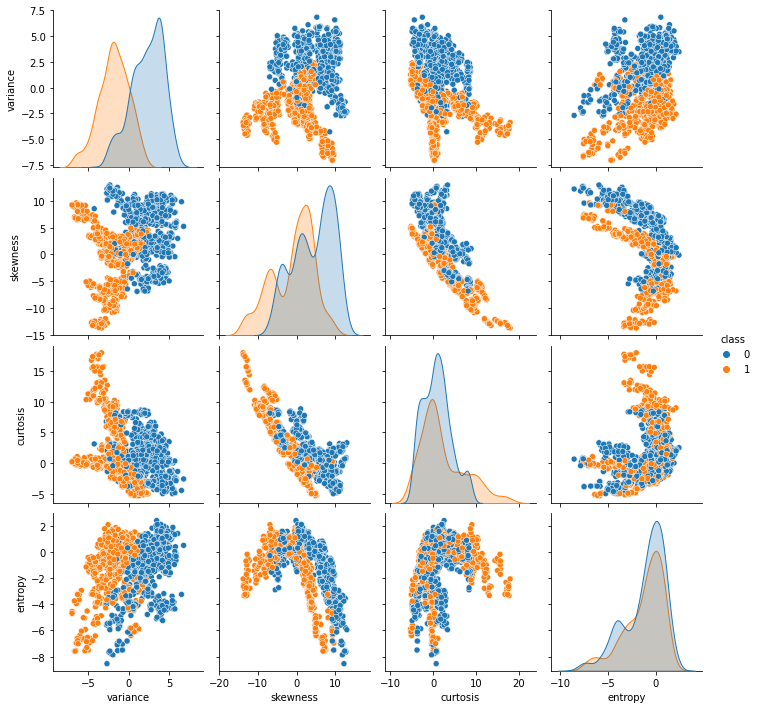

In [ ]:
ip_data = df.toPandas()
sns.pairplot(ip_data,hue="class")
plt.show()

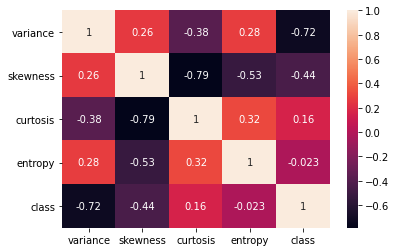

In [ ]:
cf_data=ip_data.corr()
sns.heatmap(data=cf_data,annot=True)
plt.show()

Form the above set of plots its is evident that the plots with respect to variance as a feature is highly corrleated and gives a good distinction of data points of both the classes.

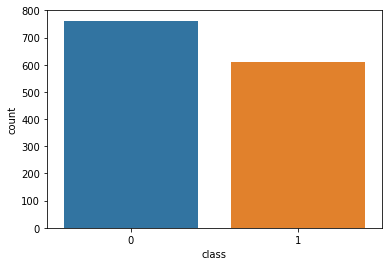

In [ ]:
sns.countplot(data=ip_data,x="class")
plt.show()

## Pipeline creation to build model

In [ ]:
from pyspark.ml.feature import VectorAssembler

stages = []
ip_cols=df.columns[:-1]
data_VA= VectorAssembler(inputCols=ip_cols,outputCol="features")

stages += [data_VA]

In [ ]:
from pyspark.ml.feature import MinMaxScaler

data_scaler=MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
stages += [data_scaler]

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)


In [ ]:
train_dt, test_dt = df.randomSplit([0.7, 0.3], seed = 40)

data_pipeline= pipeline.fit(train_dt)
final_train_data =data_pipeline.transform(train_dt)

In [ ]:
final_train_data.select('features','scaledFeatures').show(10)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[-6.2003,8.6806,0...|[0.06070570927893...|
|[-6.0598,9.2952,-...|[0.07083775032631...|
|[-5.8818,7.6584,0...|[0.08367407279204...|
|[-5.4808,8.1819,0...|[0.11259185542550...|
|[-5.1216,-5.3118,...|[0.13849526570466...|
|[-5.0676,-5.1877,...|[0.14238943094707...|
|[-4.9462,3.5716,0...|[0.15114409132538...|
|[-4.8861,7.0542,-...|[0.15547815301184...|
|[-4.6765,-5.6636,...|[0.17059328328609...|
|[-4.0679,2.4955,0...|[0.21448196785150...|
+--------------------+--------------------+
only showing top 10 rows



In [ ]:
final_test_data =data_pipeline.transform(test_dt)

In [ ]:
print("Training Dataset Count: " + str(final_train_data.count()))
print("Test Dataset Count: " + str(final_test_data.count()))

Training Dataset Count: 956
Test Dataset Count: 416


##Using Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
#Applying the Logistic regression for case 1 dataframe
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'class', maxIter=12)
lrModel = lr.fit(final_train_data)
predictions = lrModel.transform(final_test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(metricName='accuracy',labelCol = 'class')
print('Accuracy: ', evaluator.evaluate(predictions))

evaluator = MulticlassClassificationEvaluator(metricName='f1',labelCol = 'class')
print('F1 score: ', evaluator.evaluate(predictions))

Accuracy:  0.9230769230769231
F1 score:  0.9225387225387225


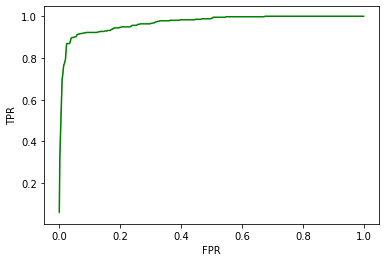

In [ ]:
data = lrModel.summary.roc.toPandas()
sns.lineplot(data=data,x='FPR',y='TPR',color='green')
plt.show()

## Using Random Forest Classifier

In [ ]:
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
rd_forest=  RandomForestClassifier(featuresCol='scaledFeatures', labelCol = 'class')
rdModel = rd_forest.fit(final_train_data)
dt_predictions = rdModel .transform(final_test_data)

evaluator = MulticlassClassificationEvaluator(metricName='accuracy',labelCol = 'class')
print("Using Decision Tree Classifier")
print('Accuracy: ', evaluator.evaluate(dt_predictions ))

evaluator = MulticlassClassificationEvaluator(metricName='f1',labelCol = 'class')
print('F1 score: ', evaluator.evaluate(dt_predictions ))

Using Decision Tree Classifier
Accuracy:  0.9759615384615384
F1 score:  0.9759732197687768


In [ ]:
dt_predictions.select( 'class','prediction', 'probability').show(10)

+-----+----------+--------------------+
|class|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.07816878866809...|
|    1|       1.0|[0.01994579315457...|
|    1|       1.0|[0.01994579315457...|
|    1|       1.0|[0.05644696441899...|
|    1|       1.0|[0.01994579315457...|
|    1|       1.0|[0.02591130450162...|
|    1|       1.0|[0.06921910339131...|
|    1|       1.0|[0.07306251119663...|
|    1|       1.0|[0.03126788510268...|
|    1|       1.0|[0.07609346794347...|
+-----+----------+--------------------+
only showing top 10 rows



In [ ]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC',labelCol = 'class')
print("Test Area Under ROC: " + str(evaluator.evaluate(dt_predictions)))

Test Area Under ROC: 0.9985867852840331


From the results it can be observed that Decision Tree Classifier performed better with an F1score of 97.59% and accuracy of 
97.59%.